<a href="https://colab.research.google.com/github/SangminAhn21/DL_Study/blob/main/Kaggle/Facial_Keypoint_Detection/FKD_model_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Colab Notebooks/Facial_Keypoint_Detection

/content/drive/MyDrive/Colab Notebooks/Facial_Keypoint_Detection


In [3]:
pip install kaggle

In [13]:
import numpy as np
import pandas as pd



training_pd = pd.read_csv('training.csv')
test_pd = pd.read_csv('test.csv')

training_pd = training_pd.dropna()
# training_pd = training_pd.fillna(method='ffill')

training = training_pd.to_numpy()
test = test_pd.to_numpy()

train_image = training[:, -1]
train_key = training[:, :-1].astype('float64')
test_image = test[:, 1]

train_image = np.array([np.array([int(pixel) for pixel in image.split()]).\
                        reshape(96, 96) for image in train_image])
test_image = np.array([np.array([int(pixel) for pixel in image.split()]).\
                       reshape(96, 96) for image in test_image])

In [14]:
training_pd.shape

(2140, 31)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class improved_CNN(nn.Module):
    def __init__(self, l1=64, l2=32):
        super(improved_CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=3,
            kernel_size=3,
            padding=1)
        self.bn1 = nn.BatchNorm2d(3)
        self.conv2 = nn.Conv2d(
            in_channels=3,
            out_channels=8,
            kernel_size=3,
            padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2)
        self.fc1 = nn.Linear(24 * 24 * 8, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 30)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = x.view(-1, 1, 96, 96)
        x = self.conv1(x)
        x = F.leaky_relu(x)
        x = self.bn1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.leaky_relu(x)
        x = self.bn2(x)
        x = self.pool(x)

        x = x.view(-1, 24 * 24 * 8)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [7]:
pip install ray

     |████████████████████████████████| 54.7 MB 169 kB/s 
     |████████████████████████████████| 119 kB 49.0 MB/s 


In [8]:
pip install -U tensorboardx

     |████████████████████████████████| 124 kB 5.4 MB/s 


In [9]:
from utils import FaceDataset, RMSELoss
from functools import partial
from models import CNN
import numpy as np
import torch
from torch.utils.data import DataLoader
import os
from filelock import FileLock
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler


def improved_cnn_train(config, data, checkpoint_dir=None, data_dir=None):
    if torch.cuda.is_available():
        DEVICE = torch.device('cuda')
    else:
        DEVICE = torch.device('cpu')
    print('Using PyTorch version:', torch.__version__, ' Device: ', DEVICE)

    model = improved_CNN(config['l1'], config['l2']).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = config['lr'])
    criterion = RMSELoss()
    print(model)


    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)


    data_dir = os.path.abspath("./data")
    dataset = FaceDataset(data[0], data[1])

    lengths = [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)]
    train_data, val_data = torch.utils.data.random_split(dataset, lengths)

    train_loader = DataLoader(dataset=train_data,
                          batch_size=config['batch_size'],
                          shuffle=True,
                          num_workers=2)
    val_loader = DataLoader(dataset=val_data,
                        batch_size=config['batch_size'],
                        shuffle=True,
                        num_workers=2)

    model.train()
    for Epoch in range(50):
        # running_loss = 0.0
        # epoch_steps = 0
        for batch_idx, (image, key) in enumerate(train_loader):
            image = image.to(DEVICE)
            key = key.to(DEVICE)
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, key)
            loss.backward()
            optimizer.step()

            # running_loss += loss.item()
            # epoch_steps += 1

            if batch_idx % 100 == 0:
                print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                    Epoch, batch_idx * len(image),
                    len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                    loss.item()))
                # running_loss = 0.0

        model.eval()
        val_loss = 0.0
        for image, key in val_loader:
            with torch.no_grad():
                image = image.to(DEVICE)
                key = key.to(DEVICE)
                output = model(image)
                val_loss += criterion(output, key).item()

        val_loss /= len(val_loader.dataset)
        val_loss *= config['batch_size']
        print('\n[EPOCH: {}], \tVal Loss: {:.4f}\n'.
        format(Epoch, val_loss))

        with tune.checkpoint_dir(Epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=val_loss)
    print("Finished Training")

In [90]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=1):
    data_dir = os.path.abspath("./data")  # 특정 경로에 대해 절대 경로 얻기
    config = {
        'l1': tune.sample_from(lambda _: 2**np.random.randint(3, 8)),
        'l2': tune.sample_from(lambda _: 2**np.random.randint(3, 8)),
        'lr': tune.loguniform(1e-3, 1e-1),
        'batch_size': tune.choice([8, 16, 32])
    }
    scheduler = ASHAScheduler(
        metric='loss',
        mode='min',
        max_t=max_num_epochs,
        grace_period=3,
        reduction_factor=2)
    
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "training_iteration"])
    
    result = tune.run(
        tune.with_parameters(partial(improved_cnn_train, data_dir=data_dir), data=(train_image, train_key)),
        resources_per_trial={'cpu': 1, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last-5-avg")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))

    best_trained_model = improved_CNN(best_trial.config["l1"], best_trial.config["l2"])
    if torch.cuda.is_available():
        DEVICE = torch.device('cuda')
    else:
        DEVICE = torch.device('cpu')
    best_trained_model.to(DEVICE)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    PATH = '/content/drive/MyDrive/Colab Notebooks/Facial_Keypoint_Detection/saved_model/'
    torch.save(best_trained_model, PATH + str(best_trial.config) + 'val_loss: ' + str(best_trial.last_result['loss']))

if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=40, gpus_per_trial=1)

== Status ==
Current time: 2021-11-24 07:58:30 (running for 00:00:00.24)
Memory usage on this node: 3.6/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 24.000: None | Iter 12.000: None | Iter 6.000: None | Iter 3.000: None
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-24_07-58-30
Number of trials: 10/10 (10 PENDING)
+----------------------------------+----------+-------+--------------+------+------+------------+
| Trial name                       | status   | loc   |   batch_size |   l1 |   l2 |         lr |
|----------------------------------+----------+-------+--------------+------+------+------------|
| tune_with_parameters_504dc_00000 | PENDING  |       |           16 |   64 |   64 | 0.0107154  |
| tune_with_parameters_504dc_00001 | PENDING  |       |           16 |  128 |   64 | 0.0392584  |
| tune_with_parameters_504dc_00002 | PENDING  |      

(pid=7189) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=7189)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=7189) Train Epoch: 0 [0/1712(0%)]	Train Loss: 51.182941
(ImplicitFunc pid=7189) Train Epoch: 0 [1600/1712(93%)]	Train Loss: 21.791040
Result for tune_with_parameters_504dc_00000:
  date: 2021-11-24_07-58-38
  done: false
  experiment_id: 40cd9b8b749e40ea9af3091ad0cc6a02
  hostname: 7d4b23a5ec39
  iterations_since_restore: 1
  loss: 10.606613551344827
  node_ip: 172.28.0.2
  pid: 7189
  should_checkpoint: true
  time_since_restore: 4.064067602157593
  time_this_iter_s: 4.064067602157593
  time_total_s: 4.064067602157593
  timestamp: 1637740718
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 504dc_00000
  
(ImplicitFunc pid=7189) 
(ImplicitFunc pid=7189) [EPOCH: 0], 	Val Loss: 10.6066
(ImplicitFunc pid=7189) 
(ImplicitFunc pid=7189) Train Epoch: 1 [0/1712(0%)]	Train Loss: 9.556102
(ImplicitFunc pid=7189) Train Epoch: 1 [1600/1712(93%)]	Train Loss: 5.109556
(ImplicitFunc pid=7189) 
(ImplicitFunc pid=7189) [EPOCH: 1], 	Val Loss: 3.6141
(ImplicitFunc pid=7

(pid=7188) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=7188)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=7188) Train Epoch: 0 [0/1712(0%)]	Train Loss: 51.281532
== Status ==
Current time: 2021-11-24 07:59:34 (running for 00:01:04.55)
Memory usage on this node: 5.1/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 24.000: -1.903761502738311 | Iter 12.000: -2.075169549924191 | Iter 6.000: -3.9588077135175186 | Iter 3.000: -3.2634769243614694
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-24_07-58-30
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------+
| Trial name                       | status     | loc             |   batch_size |   l1 |   l2 |         lr |    loss |   training_iteration |
|----------------------------------+------------+-----------------+--------------+------+------+-

(pid=8112) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=8112)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=8112) Train Epoch: 0 [0/1712(0%)]	Train Loss: 50.330708
(ImplicitFunc pid=8112) Train Epoch: 0 [1600/1712(93%)]	Train Loss: 13.861871
== Status ==
Current time: 2021-11-24 07:59:45 (running for 00:01:15.32)
Memory usage on this node: 5.1/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 24.000: -1.903761502738311 | Iter 12.000: -2.075169549924191 | Iter 6.000: -3.9588077135175186 | Iter 3.000: -3.519563149068957
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/tune_with_parameters_2021-11-24_07-58-30
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+----------------------------------+------------+-----------------+--------------+------+------+------------+---------+----------------------+
| Trial name                       | status     | loc             |   batch_size |   l1 |   l2 |         lr |    loss |   training_iteration |
|-------------------

(pid=8945) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=8945)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=8945) Train Epoch: 0 [0/1712(0%)]	Train Loss: 50.867588
Result for tune_with_parameters_504dc_00003:
  date: 2021-11-24_08-00-44
  done: false
  experiment_id: 663aca90b97244ee99f19c792713a67c
  hostname: 7d4b23a5ec39
  iterations_since_restore: 1
  loss: 44.661568614924064
  node_ip: 172.28.0.2
  pid: 8945
  should_checkpoint: true
  time_since_restore: 3.6352696418762207
  time_this_iter_s: 3.6352696418762207
  time_total_s: 3.6352696418762207
  timestamp: 1637740844
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 504dc_00003
  
== Status ==
Current time: 2021-11-24 08:00:44 (running for 00:02:14.47)
Memory usage on this node: 5.2/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 24.000: -1.8615990977420984 | Iter 12.000: -2.0249568769864945 | Iter 6.000: -3.2085934999947234 | Iter 3.000: -3.2634769243614694
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /ro

(pid=9036) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=9036)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=9036) Train Epoch: 0 [0/1712(0%)]	Train Loss: 51.366745
(ImplicitFunc pid=9036) Train Epoch: 0 [800/1712(47%)]	Train Loss: 35.327564
(ImplicitFunc pid=9036) Train Epoch: 0 [1600/1712(93%)]	Train Loss: 31.019598
Result for tune_with_parameters_504dc_00004:
  date: 2021-11-24_08-00-54
  done: false
  experiment_id: 2b469a955a0d4acf842b312fa6db0bb4
  hostname: 7d4b23a5ec39
  iterations_since_restore: 1
  loss: 24.46262637699876
  node_ip: 172.28.0.2
  pid: 9036
  should_checkpoint: true
  time_since_restore: 4.926730155944824
  time_this_iter_s: 4.926730155944824
  time_total_s: 4.926730155944824
  timestamp: 1637740854
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 504dc_00004
  
(ImplicitFunc pid=9036) 
(ImplicitFunc pid=9036) [EPOCH: 0], 	Val Loss: 24.4626
(ImplicitFunc pid=9036) 
(ImplicitFunc pid=9036) Train Epoch: 1 [0/1712(0%)]	Train Loss: 22.622297
(ImplicitFunc pid=9036) Train Epoch: 1 [800/1712(47%)]	Train Loss: 3.844552
(ImplicitFunc pid=9036

(pid=9126) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=9126)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=9126) Train Epoch: 0 [0/1712(0%)]	Train Loss: 50.950569
(ImplicitFunc pid=9126) Train Epoch: 0 [1600/1712(93%)]	Train Loss: 12.199120
Result for tune_with_parameters_504dc_00005:
  date: 2021-11-24_08-01-05
  done: false
  experiment_id: 7519ee6e35f047da818aa2272ac860e2
  hostname: 7d4b23a5ec39
  iterations_since_restore: 1
  loss: 29.730996319066698
  node_ip: 172.28.0.2
  pid: 9126
  should_checkpoint: true
  time_since_restore: 4.060785293579102
  time_this_iter_s: 4.060785293579102
  time_total_s: 4.060785293579102
  timestamp: 1637740865
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 504dc_00005
  
(ImplicitFunc pid=9126) 
(ImplicitFunc pid=9126) [EPOCH: 0], 	Val Loss: 29.7310
(ImplicitFunc pid=9126) 
(ImplicitFunc pid=9126) Train Epoch: 1 [0/1712(0%)]	Train Loss: 29.095310
(ImplicitFunc pid=9126) Train Epoch: 1 [1600/1712(93%)]	Train Loss: 3.749107
== Status ==
Current time: 2021-11-24 08:01:06 (running for 00:02:36.25)
Memory usage on this nod

(pid=9278) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=9278)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=9278) Train Epoch: 0 [0/1712(0%)]	Train Loss: 51.326027
(ImplicitFunc pid=9278) Train Epoch: 0 [1600/1712(93%)]	Train Loss: 23.721272
Result for tune_with_parameters_504dc_00006:
  date: 2021-11-24_08-01-18
  done: false
  experiment_id: 1abfe9d759d74ae4a52cd4b162154b7f
  hostname: 7d4b23a5ec39
  iterations_since_restore: 1
  loss: 33.279791787406
  node_ip: 172.28.0.2
  pid: 9278
  should_checkpoint: true
  time_since_restore: 4.087630033493042
  time_this_iter_s: 4.087630033493042
  time_total_s: 4.087630033493042
  timestamp: 1637740878
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 504dc_00006
  
(ImplicitFunc pid=9278) 
(ImplicitFunc pid=9278) [EPOCH: 0], 	Val Loss: 33.2798
(ImplicitFunc pid=9278) 
(ImplicitFunc pid=9278) Train Epoch: 1 [0/1712(0%)]	Train Loss: 32.835705
(ImplicitFunc pid=9278) Train Epoch: 1 [1600/1712(93%)]	Train Loss: 5.047678
(ImplicitFunc pid=9278) 
(ImplicitFunc pid=9278) [EPOCH: 1], 	Val Loss: 3.4098
(ImplicitFunc pid=927

(pid=9547) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=9547)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=9547) Train Epoch: 0 [0/1712(0%)]	Train Loss: 51.939289
(ImplicitFunc pid=9547) Train Epoch: 0 [800/1712(47%)]	Train Loss: 19.974001
(ImplicitFunc pid=9547) Train Epoch: 0 [1600/1712(93%)]	Train Loss: 19.724520
Result for tune_with_parameters_504dc_00007:
  date: 2021-11-24_08-01-40
  done: false
  experiment_id: 6a2fc64cc5cc445cb77d3901bd50ebce
  hostname: 7d4b23a5ec39
  iterations_since_restore: 1
  loss: 22.969548840389074
  node_ip: 172.28.0.2
  pid: 9547
  should_checkpoint: true
  time_since_restore: 4.936206817626953
  time_this_iter_s: 4.936206817626953
  time_total_s: 4.936206817626953
  timestamp: 1637740900
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 504dc_00007
  
(ImplicitFunc pid=9547) 
(ImplicitFunc pid=9547) [EPOCH: 0], 	Val Loss: 22.9695
(ImplicitFunc pid=9547) 
(ImplicitFunc pid=9547) Train Epoch: 1 [0/1712(0%)]	Train Loss: 22.312086
(ImplicitFunc pid=9547) Train Epoch: 1 [800/1712(47%)]	Train Loss: 3.868646
(ImplicitFunc pid=954

(pid=9817) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=9817)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=9817) Train Epoch: 0 [0/1712(0%)]	Train Loss: 51.452568
Result for tune_with_parameters_504dc_00008:
  date: 2021-11-24_08-02-11
  done: false
  experiment_id: c206d51582484415b6f7cd46e8aa4ced
  hostname: 7d4b23a5ec39
  iterations_since_restore: 1
  loss: 42.692078207140774
  node_ip: 172.28.0.2
  pid: 9817
  should_checkpoint: true
  time_since_restore: 3.585425853729248
  time_this_iter_s: 3.585425853729248
  time_total_s: 3.585425853729248
  timestamp: 1637740931
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 504dc_00008
  
== Status ==
Current time: 2021-11-24 08:02:11 (running for 00:03:41.35)
Memory usage on this node: 5.3/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 24.000: -1.8615990977420984 | Iter 12.000: -2.296855694779726 | Iter 6.000: -3.046706529421227 | Iter 3.000: -3.261265759156129
Resources requested: 1.0/2 CPUs, 1.0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray

(pid=9910) /content/drive/My Drive/Colab Notebooks/Facial_Keypoint_Detection/utils.py:11: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
(pid=9910)   self.x_data = (torch.from_numpy(x)/255.).type('torch.FloatTensor')


(ImplicitFunc pid=9910) Train Epoch: 0 [0/1712(0%)]	Train Loss: 51.603420
(ImplicitFunc pid=9910) Train Epoch: 0 [800/1712(47%)]	Train Loss: 41.303268
(ImplicitFunc pid=9910) Train Epoch: 0 [1600/1712(93%)]	Train Loss: 18.653753
Result for tune_with_parameters_504dc_00009:
  date: 2021-11-24_08-02-21
  done: false
  experiment_id: 186d4056c0e4404782bc1c7a8300641d
  hostname: 7d4b23a5ec39
  iterations_since_restore: 1
  loss: 25.432847174528604
  node_ip: 172.28.0.2
  pid: 9910
  should_checkpoint: true
  time_since_restore: 5.033922433853149
  time_this_iter_s: 5.033922433853149
  time_total_s: 5.033922433853149
  timestamp: 1637740941
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 504dc_00009
  (ImplicitFunc pid=9910) 
(ImplicitFunc pid=9910) [EPOCH: 0], 	Val Loss: 25.4328
(ImplicitFunc pid=9910) 

(ImplicitFunc pid=9910) Train Epoch: 1 [0/1712(0%)]	Train Loss: 24.471090
(ImplicitFunc pid=9910) Train Epoch: 1 [800/1712(47%)]	Train Loss: 3.613387
(ImplicitFunc pid=991

2021-11-24 08:02:25,874	INFO tune.py:630 -- Total run time: 235.45 seconds (235.30 seconds for the tuning loop).


Result for tune_with_parameters_504dc_00009:
  date: 2021-11-24_08-02-25
  done: true
  experiment_id: 186d4056c0e4404782bc1c7a8300641d
  hostname: 7d4b23a5ec39
  iterations_since_restore: 3
  loss: 3.8162507788043154
  node_ip: 172.28.0.2
  pid: 9910
  should_checkpoint: true
  time_since_restore: 9.639986276626587
  time_this_iter_s: 2.297236442565918
  time_total_s: 9.639986276626587
  timestamp: 1637740945
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 504dc_00009
  
(ImplicitFunc pid=9910) 
(ImplicitFunc pid=9910) [EPOCH: 2], 	Val Loss: 3.8163
(ImplicitFunc pid=9910) 
== Status ==
Current time: 2021-11-24 08:02:25 (running for 00:03:55.32)
Memory usage on this node: 5.1/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 24.000: -1.8615990977420984 | Iter 12.000: -2.296855694779726 | Iter 6.000: -3.046706529421227 | Iter 3.000: -3.3469769887835064
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects (0.0/1.0 accelerator_type:K8

In [ ]:
dataset = FaceDataset(train_image, train_key)

lengths = [int(len(dataset)*0.8), len(dataset) - int(len(dataset)*0.8)]
train_data, val_data = torch.utils.data.random_split(dataset, lengths)

train_loader = DataLoader(dataset=train_data,
                          batch_size=16,
                          shuffle=True,
                          num_workers=2)
val_loader = DataLoader(dataset=val_data,
                        batch_size=16,
                        shuffle=True,
                        num_workers=2)

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, key) in enumerate(train_loader):
        image = image.to(DEVICE)
        key = key.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, key)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, key in val_loader:
            image = image.to(DEVICE)
            key = key.to(DEVICE)
            output = model(image)
            val_loss += criterion(output, key).item()

    val_loss /= len(val_loader.dataset)
    val_loss *= 16
    return val_loss

In [ ]:
test_model = improved_CNN(l1=16, l2=16)
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

test_model.to(DEVICE)

optimizer = torch.optim.Adam(test_model.parameters(), lr = 0.005)
criterion = RMSELoss()

In [ ]:
for Epoch in range(1, 50 + 1):
    train(test_model, train_loader, optimizer, log_interval = 100)
    val_loss = evaluate(test_model, val_loader)
    print('\n[EPOCH: {}], \tVal Loss: {:.4f}\n'.
          format(Epoch, val_loss))

Train Epoch: 1 [0/5639(0%)]	Train Loss: 51.847679
Train Epoch: 1 [1600/5639(28%)]	Train Loss: 20.160702
Train Epoch: 1 [3200/5639(57%)]	Train Loss: 20.185585
Train Epoch: 1 [4800/5639(85%)]	Train Loss: 25.803709

[EPOCH: 1], 	Val Loss: 27.4746

Train Epoch: 2 [0/5639(0%)]	Train Loss: 21.505964
Train Epoch: 2 [1600/5639(28%)]	Train Loss: 19.210417
Train Epoch: 2 [3200/5639(57%)]	Train Loss: 21.712437
Train Epoch: 2 [4800/5639(85%)]	Train Loss: 21.798086

[EPOCH: 2], 	Val Loss: 19.8322

Train Epoch: 3 [0/5639(0%)]	Train Loss: 21.945637
Train Epoch: 3 [1600/5639(28%)]	Train Loss: 19.015829
Train Epoch: 3 [3200/5639(57%)]	Train Loss: 19.810150
Train Epoch: 3 [4800/5639(85%)]	Train Loss: 15.587580

[EPOCH: 3], 	Val Loss: 23.4501

Train Epoch: 4 [0/5639(0%)]	Train Loss: 19.098373
Train Epoch: 4 [1600/5639(28%)]	Train Loss: 23.404871
Train Epoch: 4 [3200/5639(57%)]	Train Loss: 18.212337
Train Epoch: 4 [4800/5639(85%)]	Train Loss: 23.424971

[EPOCH: 4], 	Val Loss: 22.6138

Train Epoch: 5 [0/56

In [91]:
best_model = torch.load("/content/drive/MyDrive/Colab Notebooks/Facial_Keypoint_Detection/saved_model/{'l1': 128, 'l2': 128, 'lr': 0.0010379776478907162, 'batch_size': 16}val_loss: 1.8288547613910426")

In [17]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [31]:
import matplotlib.pyplot as plt

In [55]:
def predict(model, test_image, idx, plot=False):
    image_pred = torch.from_numpy(test_image[idx]).type(torch.FloatTensor).to(DEVICE)
    image_pred /= 255.
    model.eval()
    with torch.no_grad():
        prediction = model(image_pred)
        print(prediction)
    image_pred = image_pred.cpu().numpy()*255.
    prediction = prediction.cpu().numpy().reshape(30)
    # answer = val_data[idx][1]

    if plot:
        fig, axis = plt.subplots()
        prediction_plot(image_pred, prediction, axis,\
                        'prediction plot for {}th image in val_data'.
                        format(idx))


def prediction_plot(image, keypoint, axis, title, answer=None):
    image = image.reshape(96, 96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    # axis.scatter(answer[0::2], answer[1::2], marker='x', color='r', s=20)
    plt.title(title)


tensor([[64.6764, 36.0455, 30.2624, 34.6959, 59.3086, 37.2831, 71.4462, 37.6534,
         37.5096, 35.4970, 23.7864, 35.7586, 56.1714, 27.4597, 76.2876, 31.1136,
         39.9739, 25.3867, 19.0632, 27.7206, 53.0837, 54.4316, 59.4383, 77.9416,
         38.5160, 76.7086, 50.5363, 71.9189, 49.3605, 80.2081]],
       device='cuda:0')


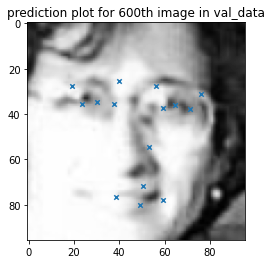

In [109]:
predict(model=best_model, test_image=test_image, idx=600, plot=True)

In [94]:
def submit(model, test_image ):
    test_image = torch.from_numpy(test_image).type(torch.FloatTensor).to(DEVICE)
    test_image /= 255.
    model.eval()
    with torch.no_grad():
        prediction = model(test_image)
    prediction = prediction.cpu().numpy()
    return prediction

In [95]:
pred = submit(best_model, test_image)

In [81]:
IdLookupTable = pd.read_csv('IdLookupTable.csv')

In [96]:
RowID = list(IdLookupTable.RowId)
ImageID = list(IdLookupTable.ImageId)
FeatureHead = list(training_pd.columns.values)
FeatureIndex = [FeatureHead.index(feature) for feature in IdLookupTable.FeatureName]

In [97]:
location = []
for image_id, feature_id in zip(ImageID, FeatureIndex):
    location.append(pred[image_id-1][feature_id])
submission = pd.DataFrame({'RowID': RowID, 'Location': location})
submission.head()

,RowID,Location
0,1,66.344727
1,2,37.767342
2,3,29.735804
3,4,37.056568
4,5,60.648464


In [98]:
def adjust_max(row):
    if row.Location > 96.:
        row.Location = 96.
    return row

submission = submission.apply(adjust_max, axis='columns')

In [99]:
submission.RowID = submission.RowID.astype('int')

In [100]:
submission.head()

,RowID,Location
0,1,66.344727
1,2,37.767342
2,3,29.735804
3,4,37.056568
4,5,60.648464


In [101]:
submission.to_csv('submission_final.csv', index=None)

In [76]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [103]:
!kaggle competitions submit -c facial-keypoints-detection -f submission_final.csv -m "FKD_improved"

100% 629k/629k [00:01<00:00, 424kB/s]
Successfully submitted to Facial Keypoints Detection